# Preliminary operations

In [1]:
#@title Drive mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#@title Main libraries
import pandas as pd
import numpy as np

import os
import random

from sklearn.utils import  compute_class_weight

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

In [3]:
#@title Reproducibility
# Setting a seed for reproducibility
seed = 90 
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print("The seed is: " + str(seed))

The seed is: 90


#Functions

In [ ]:
def unfreeze_layers(tl_model, untill, supernet_name,lr):

  tl_model.get_layer(supernet_name).trainable = True
  for i, layer in enumerate(tl_model.get_layer(supernet_name).layers[:untill]):
    layer.trainable=False
  for i, layer in enumerate(tl_model.get_layer(supernet_name).layers):
    print(i, layer.name, layer.trainable)

  tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(lr), metrics=['accuracy', 'Precision', 'Recall'])

  return tl_model

In [ ]:
def evaluate_model_m(model, test_set, target):

  """ Function used to evaluate model's performances on the local test set, display of confusion matrix """
  """ Model from trained model variable """

  labels = list(test_set.class_indices.keys())
  
  predictions = model.predict(test_set)
  metrics= {
    "predictions" : predictions,
    "target": target,
    "cm": confusion_matrix(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), normalize='true', ),
    "accuracy" : accuracy_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1)),
    "precision" : precision_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "recall" : recall_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro'),
    "f1" : f1_score(np.argmax(target, axis=-1), np.argmax(predictions, axis=-1), average='macro')  }
  
  print("Accuracy: "+ str(metrics["accuracy"]))
  print("F1 score: "+ str(metrics["f1"]))
  cm = metrics["cm"]
  plt.figure(figsize=(15,15))
  sns.heatmap(cm.T, annot=True, fmt='.2f', xticklabels=list(labels), yticklabels=list(labels))
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  return metrics

# Access data

### Data hyperparameters

In [4]:
data_hyperparameters = {
    'batch_size': 128,
    'resized_shape_height': 224, # as in chex net
    'resized_shape_width': 224,
    'color_mode': 'rgb' #'grayscale'
}

### Defining augmentation

In [5]:
# This function is used to create a dictionary with the hyperparameters of the augmentation 
def get_augmentation_hyperparameters(selected_dictionary):
  
  if selected_dictionary==0:
    augmentation_hyperparameters={}
    augmentation_hyperparameters['name']= 'Basic_Augmentation'
    augmentation_hyperparameters['rotation_range']= 45
    augmentation_hyperparameters['width_shift_range']= 0
    augmentation_hyperparameters['height_shift_range']= 0
    augmentation_hyperparameters['brightness_range']= [0.8, 1.2]
    augmentation_hyperparameters['horizontal_flip']= True
    augmentation_hyperparameters['vertical_flip']= False
    augmentation_hyperparameters['zoom_range']= [0.7, 1.2]
    augmentation_hyperparameters['rescale_range']= 1/255.
    augmentation_hyperparameters['fill_mode']= 'reflect'
    augmentation_hyperparameters['cval']= 0
    
  elif selected_dictionary==1:
    augmentation_hyperparameters={}
    augmentation_hyperparameters['name']= 'Aggressive_Augmentation'
    augmentation_hyperparameters['rotation_range']= 90
    augmentation_hyperparameters['width_shift_range']= 0.2
    augmentation_hyperparameters['height_shift_range']= 0.2
    augmentation_hyperparameters['brightness_range']= [0.5, 1.5]
    augmentation_hyperparameters['horizontal_flip']= True
    augmentation_hyperparameters['vertical_flip']= False
    augmentation_hyperparameters['zoom_range']= [0.5, 1.5]
    augmentation_hyperparameters['rescale_range']= 1/255.
    augmentation_hyperparameters['fill_mode']= 'reflect'
    augmentation_hyperparameters['cval']= 0

  elif selected_dictionary==2:
    augmentation_hyperparameters={}
    augmentation_hyperparameters['name']= 'Kind_Augmentation'
    augmentation_hyperparameters['rotation_range']= 0
    augmentation_hyperparameters['width_shift_range']= 0.1
    augmentation_hyperparameters['height_shift_range']= 0.1
    augmentation_hyperparameters['brightness_range']=  [0.9, 1.1]
    augmentation_hyperparameters['horizontal_flip']= True
    augmentation_hyperparameters['vertical_flip']= False
    augmentation_hyperparameters['zoom_range']= [0.9, 1.1]
    #augmentation_hyperparameters['rescale_range']= 1.
    augmentation_hyperparameters['fill_mode']= 'reflect'
    augmentation_hyperparameters['cval']= 0
  
  return augmentation_hyperparameters

In [6]:
dictionary = get_augmentation_hyperparameters(2)


aug_train_gen = ImageDataGenerator(
    rotation_range = dictionary['rotation_range'],
    height_shift_range = dictionary['height_shift_range'],
    width_shift_range = dictionary['width_shift_range'], 
    zoom_range = dictionary['zoom_range'],
    horizontal_flip = dictionary['horizontal_flip'],
    vertical_flip = dictionary['vertical_flip'], 
    fill_mode = dictionary['fill_mode'],
    cval = dictionary['cval'],
    #rescale = dictionary['rescale_range'],
    brightness_range = dictionary['brightness_range'],
    #preprocessing_function= preprocess_input)
)

In [ ]:
os.getcwd()

'C:\\Users\\Andrea Braccio\\Desktop'

### Data generators

In [7]:
dataset_dir = "/content/gdrive/MyDrive/Assignment/Clean_And_Preprocessed_Dataset/CLEAN_and_AP" #'/content/gdrive/MyDrive/splitted_dataset'
training_dir = os.path.join(dataset_dir, 'TRAIN')
validation_dir = os.path.join(dataset_dir, 'VAL')
test_dir = os.path.join(dataset_dir, 'TEST')

In [8]:
aug_training_set = aug_train_gen.flow_from_directory(directory = training_dir,
                                                  target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                  color_mode = data_hyperparameters['color_mode'],
                                                  class_mode = 'categorical',
                                                  batch_size = data_hyperparameters['batch_size'],
                                                  shuffle = True,
                                                  seed = seed)

noaug_training_set = ImageDataGenerator().flow_from_directory(directory = training_dir,
                                                                              target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                              color_mode = data_hyperparameters['color_mode'],
                                                                              class_mode = 'categorical',
                                                                              batch_size = data_hyperparameters['batch_size'],
                                                                              shuffle = True,
                                                                              seed = seed)

validation_set = ImageDataGenerator().flow_from_directory(directory = validation_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = True,
                                                                seed = seed)
test_set = ImageDataGenerator().flow_from_directory(directory = test_dir,
                                                                target_size = (data_hyperparameters['resized_shape_height'], data_hyperparameters['resized_shape_width']),
                                                                color_mode = data_hyperparameters['color_mode'],
                                                                class_mode = 'categorical',
                                                                batch_size = data_hyperparameters['batch_size'],
                                                                shuffle = False,
                                                                seed = seed)


Found 11124 images belonging to 3 classes.
Found 11124 images belonging to 3 classes.
Found 1253 images belonging to 3 classes.
Found 3093 images belonging to 3 classes.


In [9]:
np.save('/content/gdrive/MyDrive/AI project/models/target_ap', test_set.classes)

In [ ]:
# @title Target labels
labels = list(aug_training_set.class_indices.keys())
print("Labels: ", labels)

Labels:  ['normal', 'pneumonia', 'tubercolosis']


In [ ]:
# @title Defining input and output

n_channels = 1 if data_hyperparameters['color_mode']=='grayscale' else 3
input_shape = (data_hyperparameters['resized_shape_height'],data_hyperparameters['resized_shape_width'],n_channels) 
n_output = len(labels)

print(input_shape)
print(n_output)

(224, 224, 3)
3


# Model definition

In [ ]:
import h5py as h5py
# @title Building the model
base_model = tfk.applications.EfficientNetB0(
    include_top = False,
    weights = "imagenet",
    input_shape = input_shape
)

In [ ]:
base_model.trainable = False

In [ ]:
inputs = tfk.Input(shape = input_shape)

In [ ]:
dp_rate1 = 0.3
dp_rate2 = 0.3
nc = 512
elastic_lambda= 1e-3

x = base_model(inputs, training=False)
x = tfk.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(dp_rate1, seed=seed)(x)
x = tfkl.Dense( 
      units=nc, 
      kernel_initializer = tfk.initializers.HeUniform(seed),
      kernel_regularizer=tf.keras.regularizers.L1L2(elastic_lambda,elastic_lambda))(x)
x=tfkl.LeakyReLU()(x)
x = tfkl.Dropout(dp_rate2, seed=seed)(x)

In [ ]:
outputs = tfkl.Dense(
      n_output, 
      activation='softmax',
      kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

In [ ]:
model = tfk.Model(inputs, outputs, name='model')

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0     

In [ ]:
unfreeze_layers(model, untill=207, supernet_name='efficientnetb0', lr = 1e-3)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0     

# Model training

In [ ]:
#@title Callbacks function
Running_On_COLAB = 1
from datetime import datetime
def create_folders_and_callbacks(model_name):
    callbacks=[]
    # Early Stopping
    # --------------
    es_callback = tfk.callbacks.EarlyStopping(monitor=monmtr, patience=20, restore_best_weights=True)
    
    callbacks.append(es_callback)

    # Reduce LR by 1/2 when a plateau is reached
    reduce_LR_callback = tfk.callbacks.ReduceLROnPlateau(monitor=monmtr, patience=3, factor=0.5, min_lr=1e-8)
    callbacks.append(reduce_LR_callback)

    return callbacks

In [ ]:
train_gen = aug_training_set
valid_gen = validation_set
test_gen = test_set

train_target = train_gen.classes
val_target = valid_gen.classes
test_target = test_gen.classes

train_target_cat = tfk.utils.to_categorical(train_gen.classes)
val_target_cat = tfk.utils.to_categorical(valid_gen.classes)
test_target_cat = tfk.utils.to_categorical(test_gen.classes)

## Training 1

In [ ]:
epochs = 40
bs = data_hyperparameters['batch_size']
class_weights = dict(zip(np.unique(train_target), compute_class_weight(class_weight = "balanced", classes = np.unique(train_target), y = train_target)))
monmtr = 'val_accuracy'

In [ ]:
aug_callbacks = create_folders_and_callbacks(model_name='HMP_EffNet_Training1')

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    #class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/40
87/87 [==============================] - 132s 1s/step - loss: 10.4194 - accuracy: 0.8415 - precision: 0.8578 - recall: 0.8250 - val_loss: 1.8974 - val_accuracy: 0.9042 - val_precision: 0.9165 - val_recall: 0.8931
Epoch 2/40
87/87 [==============================] - 83s 949ms/step - loss: 0.9016 - accuracy: 0.9077 - precision: 0.9139 - recall: 0.9000 - val_loss: 0.6037 - val_accuracy: 0.8811 - val_precision: 0.8841 - val_recall: 0.8763
Epoch 3/40
87/87 [==============================] - 82s 944ms/step - loss: 0.4177 - accuracy: 0.9249 - precision: 0.9288 - recall: 0.9196 - val_loss: 0.3491 - val_accuracy: 0.9362 - val_precision: 0.9395 - val_recall: 0.9290
Epoch 4/40
87/87 [==============================] - 82s 941ms/step - loss: 0.3487 - accuracy: 0.9330 - precision: 0.9357 - recall: 0.9291 - val_loss: 0.3197 - val_accuracy: 0.9338 - val_precision: 0.9372 - val_recall: 0.9290
Epoch 5/40
87/87 [==============================] - 87s 1s/step - loss: 0.3035 - accuracy: 0.9444 - p

87/87 [==============================] - 86s 983ms/step - loss: 0.0377 - accuracy: 0.9906 - precision: 0.9908 - recall: 0.9904 - val_loss: 0.1729 - val_accuracy: 0.9521 - val_precision: 0.9528 - val_recall: 0.9513
Epoch 38/40
87/87 [==============================] - 84s 968ms/step - loss: 0.0385 - accuracy: 0.9896 - precision: 0.9897 - recall: 0.9893 - val_loss: 0.1719 - val_accuracy: 0.9521 - val_precision: 0.9521 - val_recall: 0.9521
Epoch 39/40
87/87 [==============================] - 85s 971ms/step - loss: 0.0362 - accuracy: 0.9905 - precision: 0.9907 - recall: 0.9901 - val_loss: 0.1716 - val_accuracy: 0.9529 - val_precision: 0.9529 - val_recall: 0.9521
Epoch 40/40
87/87 [==============================] - 85s 974ms/step - loss: 0.0343 - accuracy: 0.9911 - precision: 0.9911 - recall: 0.9910 - val_loss: 0.1726 - val_accuracy: 0.9521 - val_precision: 0.9528 - val_recall: 0.9513


In [ ]:
model.save("C:/Users/Andrea Braccio/Desktop/AP_EffNet_model_31_01") #save the model

C:\Anaconda\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:/Users/Andrea Braccio/Desktop/AP_EffNet_model_31_01\assets


## Model evaluation 1

Qui valuto il modello allenato precedentemente con circa (1 è stata interrotta) 20 epoche, con settato a trainable fino al layer 207.
Il modello è stato salvato in "/content/gdrive/MyDrive/MODELS/EffNet_model_04_01"

Accuracy: 0.9469770449401875
F1 score: 0.9250065383062047


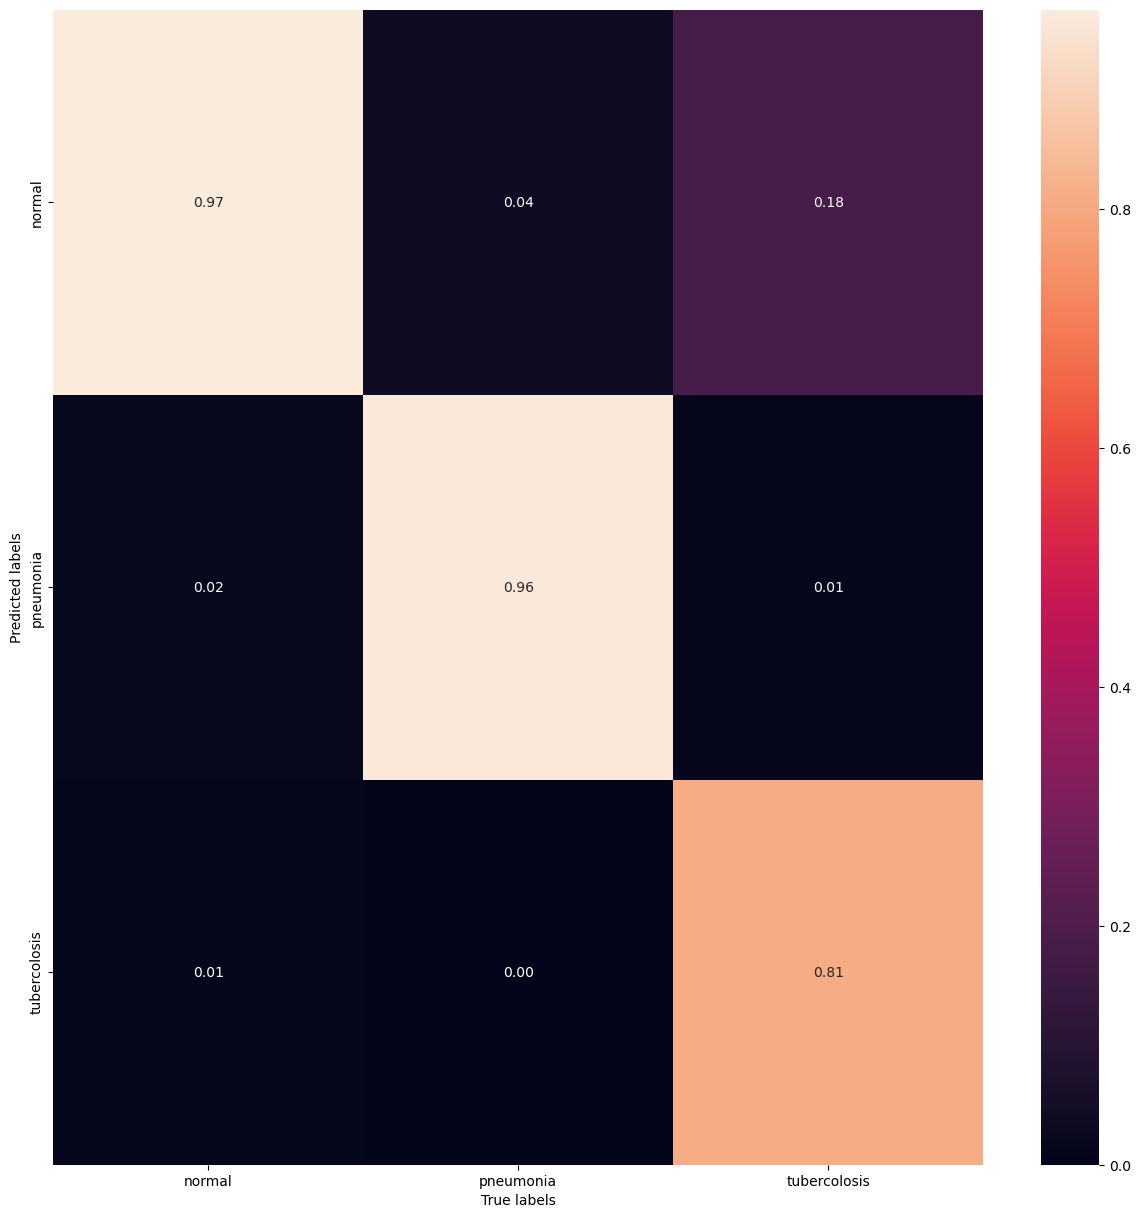

In [ ]:
train1 = evaluate_model_m(model, test_gen, test_target_cat)

##Training 2: here the secoind training phase is together resulting in 20 epochs

In [ ]:
epochs = 20
bs = data_hyperparameters['batch_size']
class_weights = dict(zip(np.unique(train_target), compute_class_weight(class_weight = "balanced", classes = np.unique(train_target), y = train_target)))
monmtr = 'val_accuracy'

In [ ]:
aug_callbacks = create_folders_and_callbacks(model_name='HMP_EffNet_Training2')

In [ ]:
unfreeze_layers(model, untill=163, supernet_name='efficientnetb0', lr = 1e-3)
model.summary()

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
history = model.fit(
    x = train_gen,
    epochs = epochs,
    #class_weight = class_weights,
    batch_size = bs, 
    validation_data = valid_gen,
    callbacks = aug_callbacks
).history

Epoch 1/20
87/87 [==============================] - 90s 986ms/step - loss: 1.5160 - accuracy: 0.7776 - precision: 0.7883 - recall: 0.7555 - val_loss: 0.5918 - val_accuracy: 0.8563 - val_precision: 0.8622 - val_recall: 0.8540
Epoch 2/20
87/87 [==============================] - 86s 986ms/step - loss: 0.4589 - accuracy: 0.8878 - precision: 0.8930 - recall: 0.8816 - val_loss: 0.4910 - val_accuracy: 0.8300 - val_precision: 0.8329 - val_recall: 0.8276
Epoch 3/20
87/87 [==============================] - 85s 980ms/step - loss: 0.3469 - accuracy: 0.9141 - precision: 0.9175 - recall: 0.9101 - val_loss: 0.2820 - val_accuracy: 0.9385 - val_precision: 0.9408 - val_recall: 0.9377
Epoch 4/20
87/87 [==============================] - 85s 977ms/step - loss: 0.2735 - accuracy: 0.9336 - precision: 0.9356 - recall: 0.9305 - val_loss: 0.2483 - val_accuracy: 0.9425 - val_precision: 0.9462 - val_recall: 0.9401
Epoch 5/20
87/87 [==============================] - 85s 972ms/step - loss: 0.2377 - accuracy: 0.9454

In [ ]:
model.save("C:/Users/Andrea Braccio/Desktop/train2_AP_EffNet_model_31_01") #save the model

In [ ]:
train2 = evaluate_model_m(model, test_gen, test_target_cat)

In [ ]:
import pickle
with open('C:/Users/Andrea Braccio/Desktop/performance2_AP_EffNet_model_31_01', 'wb') as f:
    pickle.dump(ret2, f)